In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from model_distances import distance_matrix
from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Hyperparameters

In [4]:
RERUN = False

In [5]:
EXPERIMENT_PATH = Path.cwd() / 'results' / 'hr_analysis_eurosat'

if not EXPERIMENT_PATH.is_dir():
    os.makedirs(EXPERIMENT_PATH)

In [6]:
# Test set corresponding to the data used to train the model zoo
TESTSET_DS = torch.load('/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt')['testset']
TESTSET_DL = torch.utils.data.DataLoader(TESTSET_DS, batch_size=64, shuffle=False)

# Model zoo
ZOO_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/eurosat_train_zoo_relu')
ZOO_DS = torch.load(ZOO_PATH / 'dataset_test.pt')
ZOO_DL = torch.utils.data.DataLoader(ZOO_DS, batch_size=16, shuffle=False)

ZOO_DS_TRAIN = torch.load(ZOO_PATH / 'dataset_train.pt')
ZOO_DL_TRAIN = torch.utils.data.DataLoader(ZOO_DS_TRAIN, batch_size=16, shuffle=False)

# Threshold used to define models that "perform well"; depends on the zoo
MODEL_ACC_THR = 0.7

# Path to the hyper-representation models
HYPERREP_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune/eurosat_train_hyperrep')

## Loading data

### Loading HR models meta-data

In [7]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for path in os.listdir(HYPERREP_PATH):
    if not re.match('AE_trainable', path):
        continue
    path = HYPERREP_PATH / path
    
    with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
        config = json.load(ifh_config)
        result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})
    
    for edx in range(len(result)):
        df_hr.loc[len(df_hr)] = (
            result.loc[edx]['trial_id'],
            config['optim::lr'],
            config['ae:lat_dim'],
            config['training::loss_distillation'],
            config['training::queryset_distillation'],
            config['training::queryset_dump'],
            config['training::n_queries_distillation'],
            config['training::gamma'],
            config['training::beta'],
            result.loc[edx]['training_iteration'],
            result.loc[edx]['loss/loss_train'],
            result.loc[edx]['loss/loss_contrast_train'],
            result.loc[edx]['loss/loss_recon_train'],
            result.loc[edx]['loss/loss_structure_train'],
            result.loc[edx]['loss/loss_behaviour_train'],
            result.loc[edx]['loss/loss_test'],
            result.loc[edx]['loss/loss_contrast_test'],
            result.loc[edx]['loss/loss_recon_test'],
            result.loc[edx]['loss/loss_structure_test'],
            result.loc[edx]['loss/loss_behaviour_test'],
            result.loc[edx]['dstk/test_acc_test'],
            result.loc[edx]['dstk/ggap_test']
        )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,Epoch,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,d28cf_00025,0.0001,64,distillation,data,EuroSAT,256,0.0,0.0,0,...,0.993533,0.0,0.993533,0.985235,0.0,0.985235,0.0,0.985235,0.883079,0.321712
1,d28cf_00025,0.0001,64,distillation,data,EuroSAT,256,0.0,0.0,1,...,0.012841,0.0,0.012841,0.027832,0.0,0.027832,0.0,0.027832,0.895981,0.315194
2,d28cf_00025,0.0001,64,distillation,data,EuroSAT,256,0.0,0.0,2,...,0.011913,0.0,0.011913,0.016323,0.0,0.016323,0.0,0.016323,0.896555,0.314326
3,d28cf_00025,0.0001,64,distillation,data,EuroSAT,256,0.0,0.0,3,...,0.015708,0.0,0.015708,0.024025,0.0,0.024025,0.0,0.024025,0.896595,0.313355
4,d28cf_00025,0.0001,64,distillation,data,EuroSAT,256,0.0,0.0,4,...,0.009568,0.0,0.009568,0.010813,0.0,0.010813,0.0,0.010813,0.896910,0.313311


### Loading checkpoints

In [8]:
# Loading hyper-reps
def load_hr(trial_id):
    for path in os.listdir(HYPERREP_PATH):
        if trial_id in path:
            model_path = HYPERREP_PATH / path
    return load_hyperrep_edx(model_path, MAX_EPOCH)

hyper_reps = {idx: load_hr(idx) for idx in df_hr['Trial ID'].unique()}

In [9]:
# Loading reference config
trial_id = df_hr.iloc[0]['Trial ID']
for path in os.listdir(HYPERREP_PATH):
    if trial_id in path:
        model_path = HYPERREP_PATH / path
        with open(HYPERREP_PATH / path / 'params.json') as ifh:
            ref_config = json.load(ifh)

# Loading reference params
ref_path = ref_config["training::distil_reference"]
with open(os.path.join(ref_path, 'params.json')) as ifh:
    reference_params = json.load(ifh)
    
# Loading reference checkpoint
ref_chkpth = None
for chkpth in os.listdir(ref_path):
    if 'checkpoint_' in chkpth:
        if not ref_chkpth or int(chkpth.split('_')[-1]) > int(ref_chkpth.split('_')[-1]):
            ref_chkpth = chkpth

reference_checkpoint = torch.load(Path(ref_path) / str(ref_chkpth) / 'checkpoints', map_location=torch.device("cpu"))
reference_checkpoint_cuda = {k: v.to('cuda') for k, v in deepcopy(reference_checkpoint).items()}

## Analysing the training loss

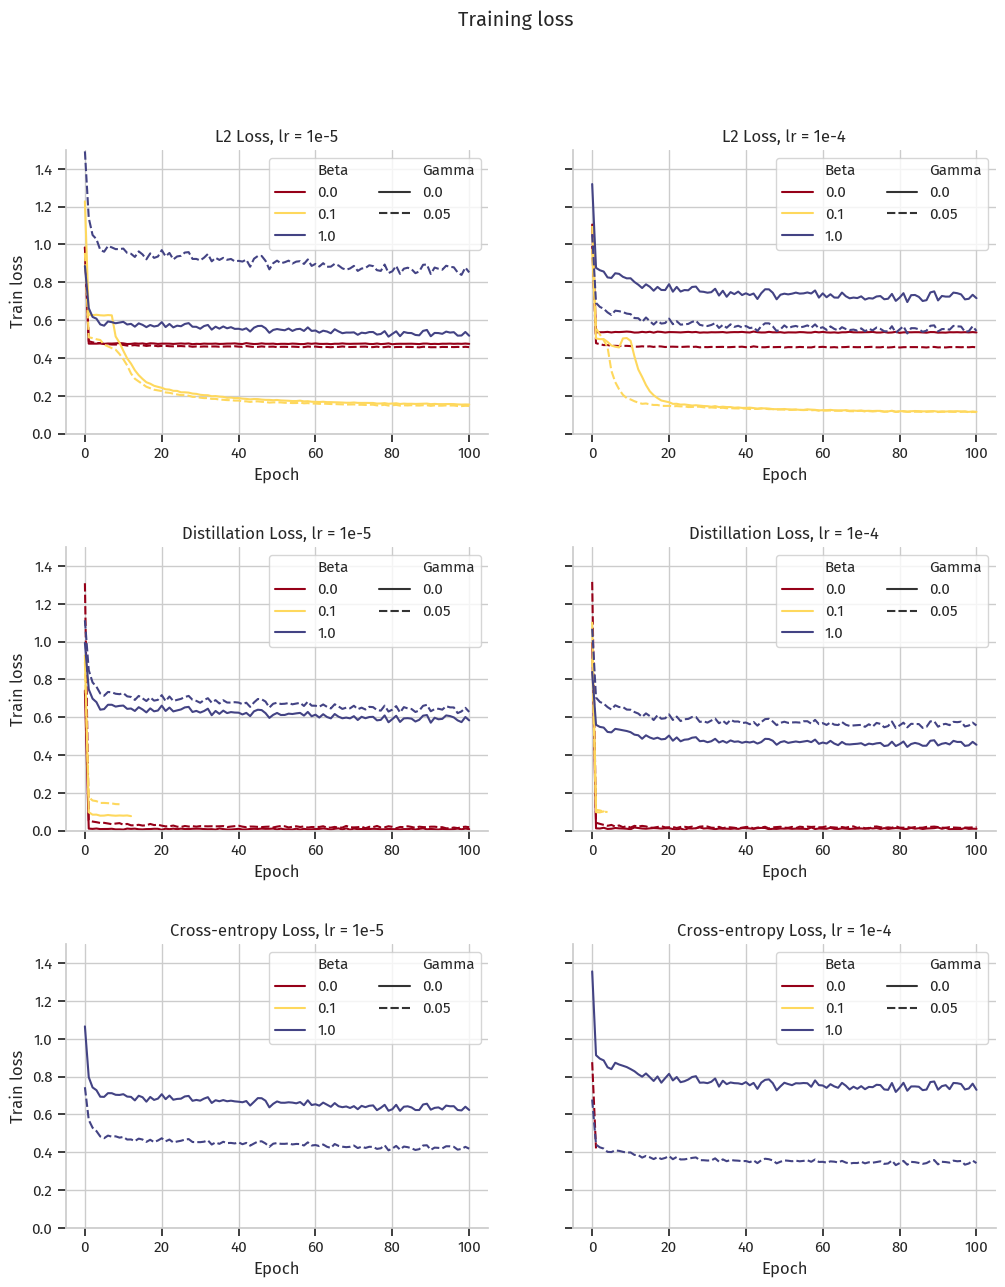

In [10]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(12, 14))

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'l2') & (df_hr['Learning rate'] == 1e-5)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[0][0]).set(
    title='L2 Loss, lr = 1e-5'
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'l2') & (df_hr['Learning rate'] == 1e-4)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[0][1]).set(
    title='L2 Loss, lr = 1e-4', ylim=(0., 1.5)
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'distillation') & (df_hr['Learning rate'] == 1e-5)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[1][0]).set(
    title='Distillation Loss, lr = 1e-5'
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'distillation') & (df_hr['Learning rate'] == 1e-4)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[1][1]).set(
    title='Distillation Loss, lr = 1e-4', ylim=(0., 1.5)
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'cross_entropy') & (df_hr['Learning rate'] == 1e-5)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[2][0]).set(
    title='Cross-entropy Loss, lr = 1e-5'
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'cross_entropy') & (df_hr['Learning rate'] == 1e-4)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[2][1]).set(
    title='Cross-entropy Loss, lr = 1e-4', ylim=(0., 1.5)
)

for ax in axs.flatten():
    ax.legend(ncol=2)

plt.suptitle('Training loss')
plt.subplots_adjust(hspace=0.40)
plt.show()

### Extracting key models

In [11]:
df_hr[(df_hr['Epoch'] == MAX_EPOCH) & (df_hr['Behaviour loss'] == 'l2')]

,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,Epoch,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
302,d28cf_00004,0.00001,64,l2,data,EuroSAT,256,0.00,1.0,100,...,0.517407,0.517407,0.000000,0.748472,0.000000,0.748472,0.748472,0.000000,0.935311,0.260450
403,d28cf_00010,0.00001,64,l2,data,EuroSAT,256,0.05,1.0,100,...,0.893007,0.893007,0.000000,1.233713,0.319473,1.281831,1.281831,0.000000,0.949818,0.408585
807,d28cf_00009,0.00010,64,l2,data,EuroSAT,256,0.05,0.1,100,...,0.117895,0.617386,0.062396,0.141606,0.126279,0.142413,0.771686,0.072494,0.983024,0.623544
908,d28cf_00003,0.00010,64,l2,data,EuroSAT,256,0.00,0.1,100,...,0.115284,0.662928,0.054434,0.141328,0.000000,0.141328,0.830902,0.064709,0.984058,0.616272
1615,d28cf_00001,0.00010,64,l2,data,EuroSAT,256,0.00,0.0,100,...,0.534961,0.000000,0.534961,0.533183,0.000000,0.533183,0.000000,0.533183,0.943571,0.449419
1716,d28cf_00007,0.00010,64,l2,data,EuroSAT,256,0.05,0.0,100,...,0.478548,0.000000,0.478548,0.457390,0.089005,0.476778,0.000000,0.476778,0.963891,0.530346
2120,d28cf_00008,0.00001,64,l2,data,EuroSAT,256,0.05,0.1,100,...,0.149865,0.887436,0.067913,0.174474,0.284862,0.168664,1.076722,0.067769,0.969290,0.528638
2221,d28cf_00002,0.00001,64,l2,data,EuroSAT,256,0.00,0.1,100,...,0.153765,0.715594,0.091339,0.169478,0.000000,0.169478,0.868098,0.091853,0.966495,0.484092
2827,d28cf_00011,0.00010,64,l2,data,EuroSAT,256,0.05,1.0,100,...,0.569155,0.569155,0.000000,0.866255,0.137753,0.904598,0.904598,0.000000,0.957421,0.465414
3029,d28cf_00005,0.00010,64,l2,data,EuroSAT,256,0.00,1.0,100,...,0.716043,0.716043,0.000000,1.129177,0.000000,1.129177,1.129177,0.000000,0.953867,0.471478


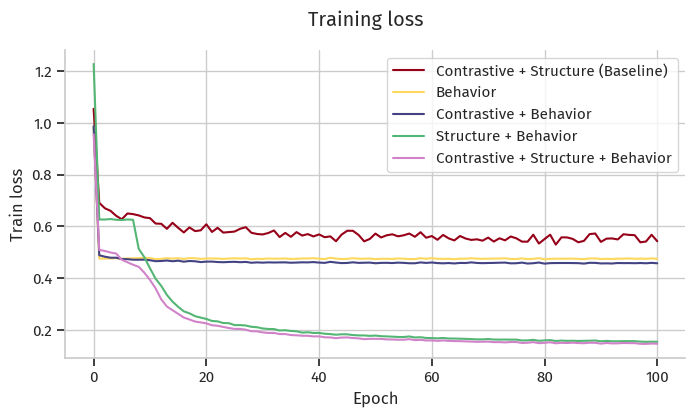

In [12]:
idx_dict = {
    'd28cf_00011': 'Contrastive + Structure (Baseline)',
    'd28cf_00000': 'Behavior',
    'd28cf_00006': 'Contrastive + Behavior',
    'd28cf_00002': 'Structure + Behavior',
    'd28cf_00008': 'Contrastive + Structure + Behavior'
}
idx_ref_chk = list(idx_dict.keys())[0]
f"Reference checkpoint: {idx_ref_chk}"


_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Train loss', color=COLOURS[i], label=label, ax=ax)
    
plt.legend()
plt.suptitle('Training loss')
plt.show()

## Analysing discriminative downstream tasks

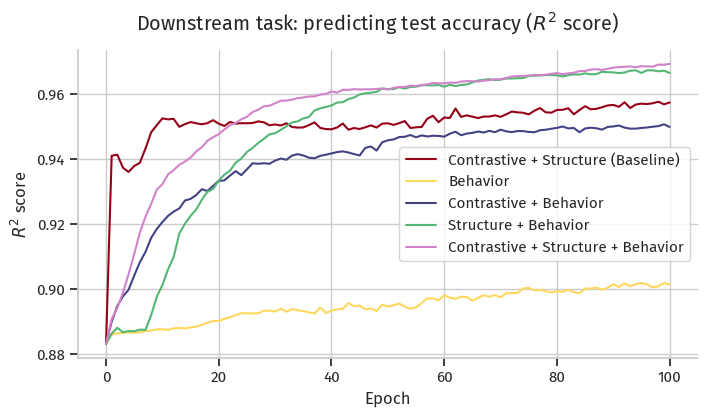

In [13]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: Test accuracy', color=COLOURS[i], label=label, ax=ax)
    
ax.set(ylabel='$R^2$ score')
    
plt.legend()
plt.suptitle('Downstream task: predicting test accuracy ($R^2$ score)')
plt.show()

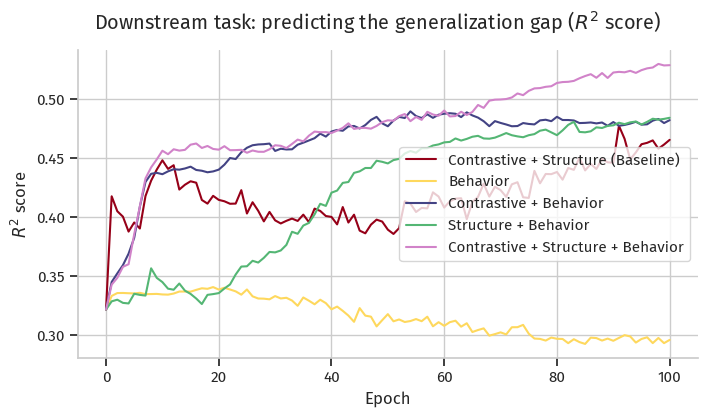

In [14]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: GGap', color=COLOURS[i], label=label, ax=ax)
    
ax.set(ylabel='$R^2$ score')
    
plt.legend()
plt.suptitle('Downstream task: predicting the generalization gap ($R^2$ score)')
plt.show()

## Analysing reconstruction

In [15]:
def compute_reconstruction_acc(hr, x, p, i, dataloader):
    z, y, zp = hr.forward(x, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return test_model(model, dataloader, device='cuda')

### Distribution of reconstructed accuracies

In [16]:
DF_ZOO_ACC_PATH = EXPERIMENT_PATH / 'df_zoo_acc.csv'
DF_Z_PATH = EXPERIMENT_PATH / 'df_z_dict.csv'
DF_X_PATH = EXPERIMENT_PATH / 'df_x_dict.csv'

X_DIM_1, X_DIM_2 = next(iter(ZOO_DL))[0].shape[1:3]
X_COLS = [f'Dimension {i}' for i in range(X_DIM_1 * X_DIM_2)]

Z_DIM_1 = X_DIM_1
Z_DIM_2 = 64
Z_COLS = [f'Dimension {i}' for i in range(Z_DIM_1 * Z_DIM_2)]

if not DF_ZOO_ACC_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_acc = pd.DataFrame(columns=['Model index', 'Hyper-representation model', 'Original accuracy', 'Reconstruction accuracy'])
    df_x = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + X_COLS)
    df_z = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + Z_COLS)

    # Run experiments
    for bdx, data in enumerate(tqdm(ZOO_DL)):
        x, m, p, _ = data

        for hr_idx, hr_label in idx_dict.items():
            z, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            for idx in range(x.shape[0]):
                # Original accuracy
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)
                orig_acc = test_model(orig_model, TESTSET_DL)
                
                # Reconstruction accuracy
                recon_checkpoint = tokens_to_checkpoint(y[idx], p[idx], reference_checkpoint)
                recon_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                recon_model.load_state_dict(recon_checkpoint)
                recon_acc = test_model(recon_model, TESTSET_DL)
                
                # Save results to DataFrame
                mdx = bdx * x.shape[0] + idx
                df_zoo_acc.loc[len(df_zoo_acc)] = (
                    mdx,
                    hr_label,
                    orig_acc,
                    recon_acc
                )
                df_x.loc[len(df_x)] = [mdx, hr_label] + x[idx].flatten().tolist()
                df_z.loc[len(df_z)] = [mdx, hr_label] + z[idx].flatten().tolist()

    # Save results to disk
    df_zoo_acc.to_csv(DF_ZOO_ACC_PATH)
    df_x.to_csv(DF_X_PATH)
    df_z.to_csv(DF_Z_PATH)
    
df_zoo_acc = pd.read_csv(DF_ZOO_ACC_PATH, index_col=0)
df_x = pd.read_csv(DF_X_PATH, index_col=0)
df_z = pd.read_csv(DF_Z_PATH, index_col=0)
df_zoo_acc.head()

,Model index,Hyper-representation model,Original accuracy,Reconstruction accuracy
0,0,Contrastive + Structure (Baseline),0.240741,0.118272
1,1,Contrastive + Structure (Baseline),0.273827,0.117037
2,2,Contrastive + Structure (Baseline),0.241728,0.182963
3,3,Contrastive + Structure (Baseline),0.235802,0.130617
4,4,Contrastive + Structure (Baseline),0.795309,0.411852


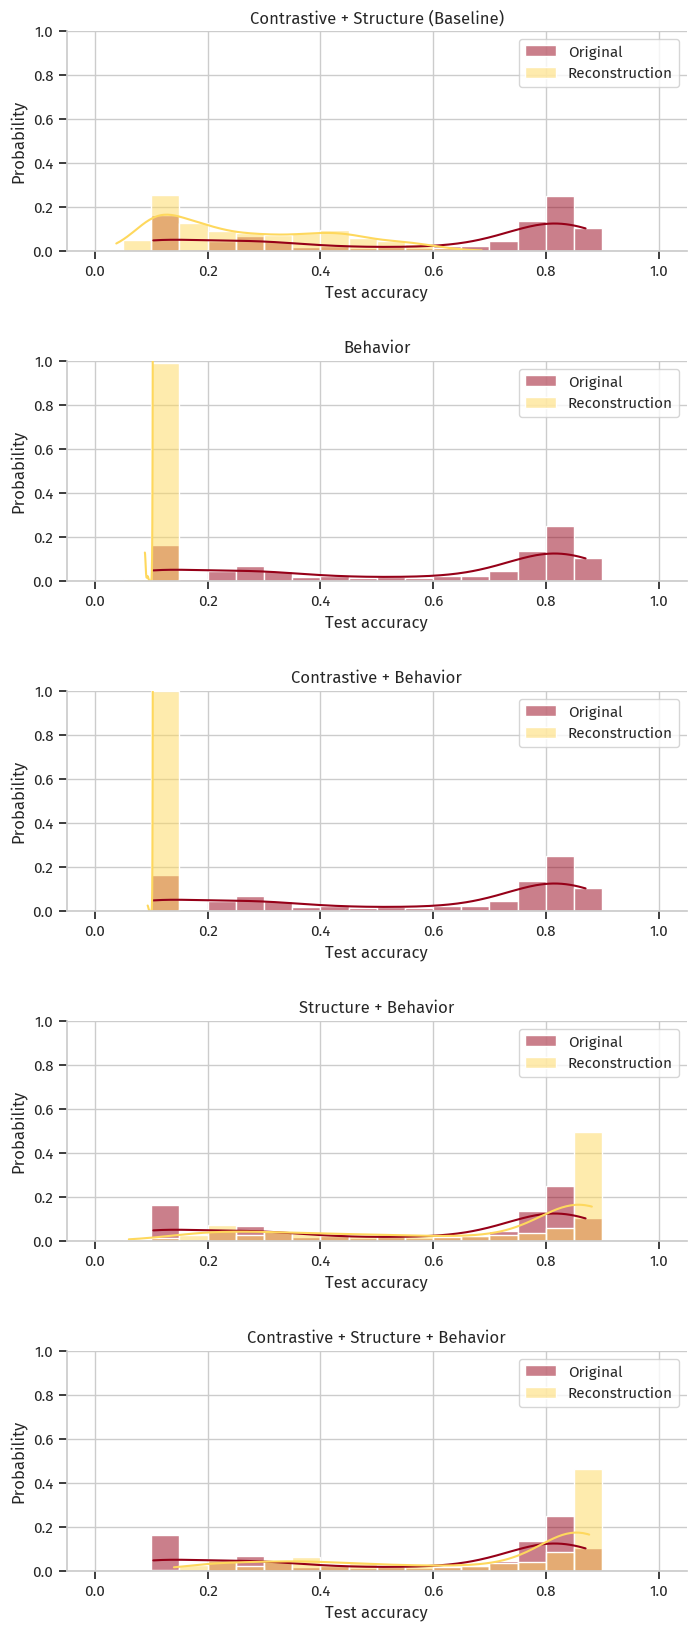

In [17]:
_, axs = plt.subplots(len(idx_dict), 1, figsize=(8, 4*len(idx_dict)))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### Pairwise $L^2$ distance between weights

In [18]:
DF_ZOO_L2WEIGHTS_PATH = EXPERIMENT_PATH / 'df_zoo_l2weights.csv'

if not DF_ZOO_L2WEIGHTS_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_l2weights = pd.DataFrame(columns=['Hyper-representation model', 'L2 (structure)', 'MSE (structure)'])

    # Run experiments
    for data in tqdm(ZOO_DL):
        x, m, p, _ = data

        for hr_idx, hr_label in idx_dict.items():
            _, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            for j in range(x.shape[0]):
                df_zoo_l2weights.loc[len(df_zoo_l2weights)] = (
                    hr_label,
                    torch.sqrt(torch.sum((x[j] - y[j]) ** 2)).item(),
                    torch.mean((x[j] - y[j]) ** 2).item()
                )
                
    # Save results
    df_zoo_l2weights.to_csv(DF_ZOO_L2WEIGHTS_PATH)
    
df_zoo_l2weights = pd.read_csv(DF_ZOO_L2WEIGHTS_PATH, index_col=0)
df_zoo_l2weights.head()

,Hyper-representation model,L2 (structure),MSE (structure)
0,Contrastive + Structure (Baseline),54.993130,0.112522
1,Contrastive + Structure (Baseline),52.678055,0.103247
2,Contrastive + Structure (Baseline),52.184288,0.101321
3,Contrastive + Structure (Baseline),49.717228,0.091967
4,Contrastive + Structure (Baseline),23.154524,0.019948


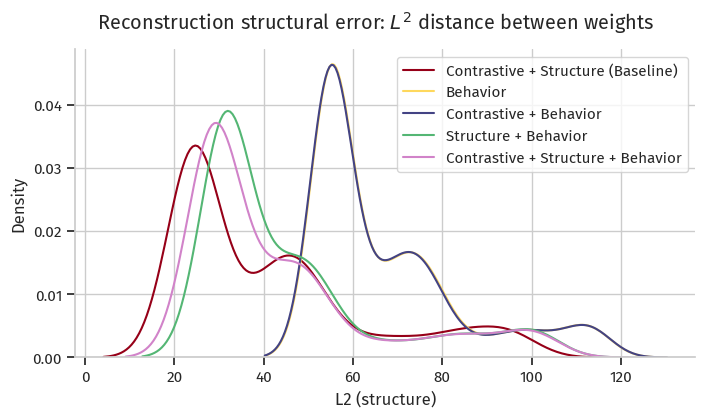

In [19]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.kdeplot(df_zoo_l2weights[df_zoo_l2weights['Hyper-representation model'] == label], x='L2 (structure)', color=COLOURS[i], label=label, ax=ax)
    
plt.legend()
plt.suptitle('Reconstruction structural error: $L^2$ distance between weights')
plt.show()

### Pairwise $L^2$ distance between predictions

In [20]:
def reconstruct_model(hr, x, p, i):
    z, y, zp = hr.forward(x, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

In [21]:
DF_ZOO_L2PREDS_PATH = EXPERIMENT_PATH / 'df_zoo_l2preds.csv'

if not DF_ZOO_L2PREDS_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_l2preds = pd.DataFrame(columns=['Hyper-representation model', 'L2 (behavior)', 'MSE (behavior)', 'Agreement'])

    # Run experiments
    for data in tqdm(ZOO_DL):
        x, m, p, _ = data

        for i in range(x.shape[0]):
            checkpoint = tokens_to_checkpoint(x[i], p[i], reference_checkpoint)
            orig_model = CNN3(
                channels_in=reference_params['model::channels_in'],
                nlin=reference_params['model::nlin'],
                dropout=reference_params['model::dropout']
            )
            orig_model.load_state_dict(checkpoint)

            for hr_idx, hr_label in idx_dict.items():   
                recon_model = reconstruct_model(hyper_reps[hr_idx], x, p, i)
                
                l2_dist, mse, agreement = compare_models_prediction(orig_model, recon_model, TESTSET_DL, n_batches=None)
                
                df_zoo_l2preds.loc[len(df_zoo_l2preds)] = (
                    hr_label,
                    l2_dist,
                    mse,
                    agreement
                )
                    
                
    # Save results
    df_zoo_l2preds.to_csv(DF_ZOO_L2PREDS_PATH)
    
df_zoo_l2preds = pd.read_csv(DF_ZOO_L2PREDS_PATH, index_col=0)
df_zoo_l2preds.head()

,Hyper-representation model,L2 (behavior),MSE (behavior),Agreement
0,Contrastive + Structure (Baseline),0.881178,0.119660,0.385926
1,Behavior,0.641160,0.054532,0.383704
2,Contrastive + Behavior,0.644318,0.054744,0.010123
3,Structure + Behavior,0.617119,0.055881,0.378519
4,Contrastive + Structure + Behavior,0.612932,0.054517,0.385185


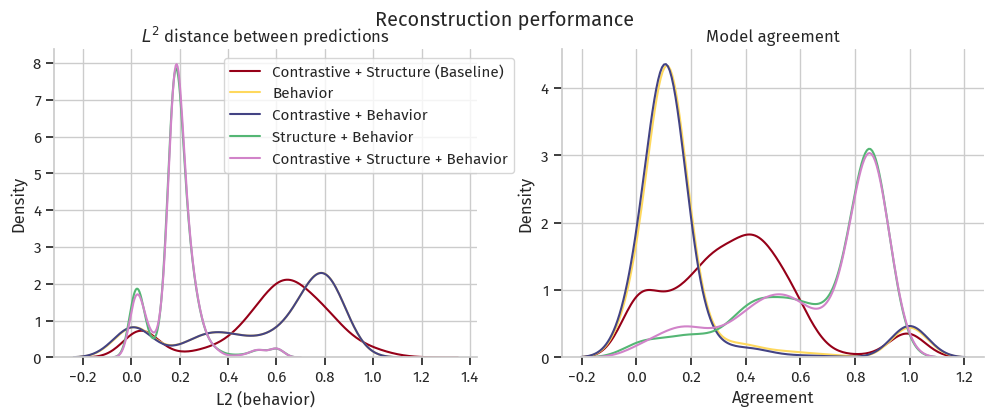

In [22]:
_, axs = plt.subplots(1 ,2, figsize=(12, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='L2 (behavior)', color=COLOURS[i], label=label, ax=axs[0])
    sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='Agreement', color=COLOURS[i], label=label, ax=axs[1])
    
    
axs[0].set(title='$L^2$ distance between predictions')
axs[1].set(title='Model agreement')
    
plt.legend(loc=(-0.80, 0.60))
plt.suptitle('Reconstruction performance')
plt.show()

## Analysing generative downstream tasks

In [23]:
def compute_acc_from_z(hr, z, p, i, dataloader):
    z = z.type(next(hr.parameters()).dtype)

    y = hr.to(z.device).forward_decoder(z, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint_cuda)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return test_model(model, dataloader)

In [24]:
# Select only models with original accuracy above a threshold
good_models_ids = df_zoo_acc[df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR]['Model index'].unique().tolist()
df_z_good_models = df_z[df_z['Model index'].isin(good_models_ids)]

# Generate anchors and samples
z_anchors = {hr_label: df_z_good_models[df_z_good_models['Hyper-representation model'] == hr_label][Z_COLS].values for hr_label in idx_dict.values()}
z_samples = {k: generate_z_samples(z) for k, z in z_anchors.items()}

# Print diagnostic statistics:
df_diagnostic = pd.DataFrame(columns=['Original std', 'Sampled std'])
for key in z_anchors.keys():
    df_diagnostic.loc[key] = (
        z_anchors[key].std(axis=0).mean(),
        z_samples[key].std(axis=0).mean()
    )
display(df_diagnostic)

# Reshape anchors and samples
z_anchors = {k: z.reshape((-1, Z_DIM_1, Z_DIM_2)) for k, z in z_anchors.items()}
z_samples = {k: z.reshape((-1, Z_DIM_1, Z_DIM_2)) for k, z in z_samples.items()}

del df_z_good_models, df_diagnostic

,Original std,Sampled std
Contrastive + Structure (Baseline),0.294386,0.246665
Behavior,0.187862,0.157544
Contrastive + Behavior,0.095189,0.081251
Structure + Behavior,0.069325,0.059606
Contrastive + Structure + Behavior,0.057848,0.051122


In [25]:
DF_GENERATIVE_PATH = EXPERIMENT_PATH / 'df_generative.csv'

if not DF_GENERATIVE_PATH.is_file() or RERUN:
    # Create dataframe
    df_generative = pd.DataFrame(columns=['Hyper-representation model', 'Origin', 'Accuracy'])
    
    p = next(iter(ZOO_DL))[2]

    for hr_idx, hr_label in tqdm(idx_dict.items(), unit='hyperrepresentation model'):
        z = torch.tensor(z_samples[hr_label]).to('cuda')
        p_z = p[0].repeat(z.shape[0], 1, 1).to('cuda') 
        
        for i in range(z.shape[0]):
            recon_acc = compute_acc_from_z(hyper_reps[hr_idx], z, p_z, i, TESTSET_DL)
            df_generative.loc[len(df_generative)] = (
                hr_label,
                'Generated',
                recon_acc
            )
                
    # Save results
    df_generative.to_csv(DF_GENERATIVE_PATH)
    
df_generative = pd.read_csv(DF_GENERATIVE_PATH, index_col=0)
df_generative.head()

,Hyper-representation model,Origin,Accuracy
0,Contrastive + Structure (Baseline),Generated,0.365185
1,Contrastive + Structure (Baseline),Generated,0.251605
2,Contrastive + Structure (Baseline),Generated,0.212840
3,Contrastive + Structure (Baseline),Generated,0.167160
4,Contrastive + Structure (Baseline),Generated,0.420000


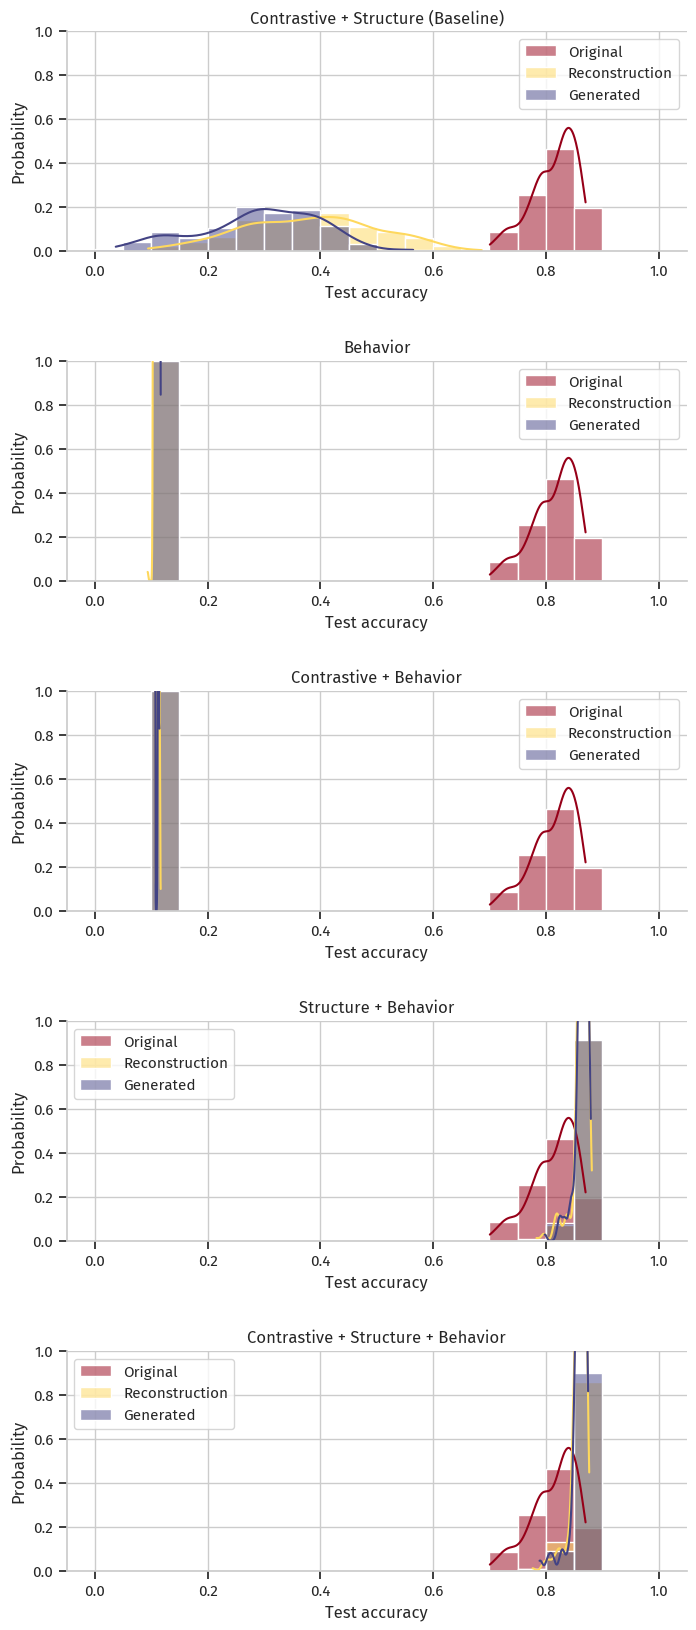

In [26]:
n_figures = len(df_generative['Hyper-representation model'].unique())

fig, axs = plt.subplots(n_figures, figsize=(8, 4*n_figures))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.histplot(df_zoo_acc[(df_zoo_acc['Hyper-representation model'] == label) & (df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR)], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[(df_zoo_acc['Hyper-representation model'] == label) & (df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR)], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    sns.histplot(
        df_generative[(df_generative['Hyper-representation model'] == label) & (df_generative['Origin'] == 'Generated')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[2],
        alpha=0.5,
        label='Generated',
        ax=axs[i]
    )
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### Verifying model diversity

In [27]:
def x_to_checkpoint(x, p, i):
    checkpoint = tokens_to_checkpoint(x[i], p[i], reference_checkpoint_cuda)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

def z_to_checkpoint(hr, z, p, i):
    z = z.type(next(hr.parameters()).dtype)

    y = hr.to(z.device).forward_decoder(z, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint_cuda)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

In [28]:
GEN_DIVERSITY_PATH = EXPERIMENT_PATH / 'gen_diversity.json'

if not GEN_DIVERSITY_PATH.is_file() or RERUN:
    gen_diversity = dict()
    
    p = next(iter(ZOO_DL))[2]
    
    # Original model zoo
    df_x_good_models = df_x[df_x['Model index'].isin(good_models_ids)]
    x = df_x_good_models[df_x_good_models['Hyper-representation model'] == list(idx_dict.values())[0]][X_COLS].values.reshape((-1, X_DIM_1, X_DIM_2))
    x = torch.tensor(x).to('cuda')
    p_x = p[0].repeat(x.shape[0], 1, 1).to('cuda')
    original_models = [x_to_checkpoint(x, p_x, i) for i in range(x.shape[0])]
    gen_diversity['Model zoo'] = dict()
    
    # L2 (weights)
    dist_mat = distance_matrix(original_models, metric='l2')
    distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
    gen_diversity['Model zoo']['l2_structure'] = distances.tolist()
    
    # L2 (predictions)
    dist_mat = distance_matrix(original_models, metric='l2_preds', testset='data', ds_test=TESTSET_DS)
    distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
    gen_diversity['Model zoo']['l2_behaviour'] = distances.tolist()
    
    del df_x_good_models, x, original_models

    for hr_idx, hr_label in tqdm(idx_dict.items(), unit='hyperrepresentation model'):        
        z = torch.tensor(z_samples[hr_label]).to('cuda')
        p_z = p[0].repeat(z.shape[0], 1, 1).to('cuda')
        generated_models = [z_to_checkpoint(hyper_reps[hr_idx], z, p_z, i) for i in range(z.shape[0])]
        gen_diversity[hr_label] = dict()
    
        # L2 (weights)
        dist_mat = distance_matrix(generated_models, metric='l2')
        distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
        gen_diversity[hr_label]['l2_structure'] = distances.tolist()

        # L2 (predictions)
        dist_mat = distance_matrix(generated_models, metric='l2_preds', testset='data', ds_test=TESTSET_DS)
        distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
        gen_diversity[hr_label]['l2_behaviour'] = distances.tolist()
        
        del z, generated_models
                
    # Save results
    with open(GEN_DIVERSITY_PATH, 'w') as ofh:
        json.dump(gen_diversity, ofh)
    
with open(GEN_DIVERSITY_PATH, 'r') as ifh:
    gen_diversity = json.load(ifh)

  0%|          | 0/5 [00:00<?, ?hyperrepresentation model/s]

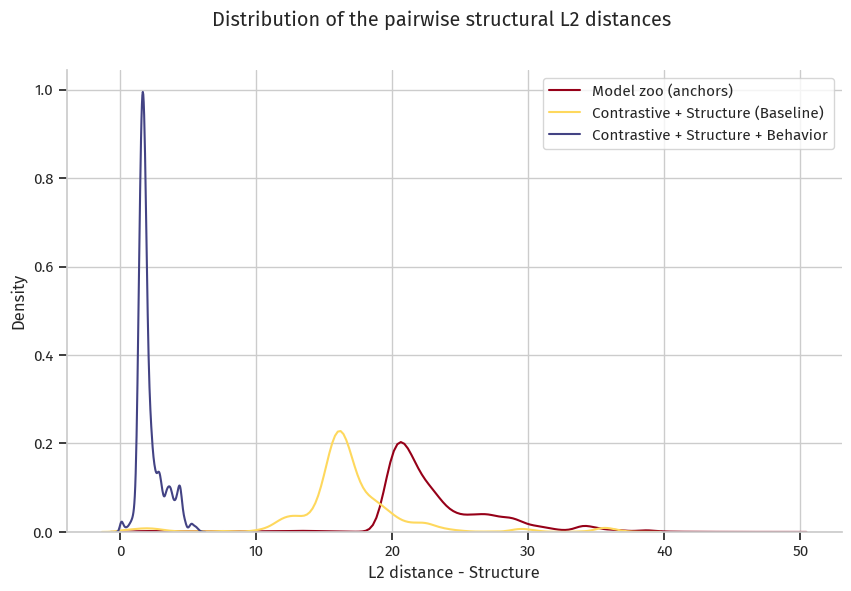

In [29]:
_, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(gen_diversity['Model zoo']['l2_structure'], color=COLOURS[0], label='Model zoo (anchors)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure (Baseline)']['l2_structure'], color=COLOURS[1], label='Contrastive + Structure (Baseline)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure + Behavior']['l2_structure'], color=COLOURS[2], label='Contrastive + Structure + Behavior', ax=ax)

ax.set(xlabel='L2 distance - Structure')

plt.legend()
plt.suptitle('Distribution of the pairwise structural L2 distances')
plt.show()

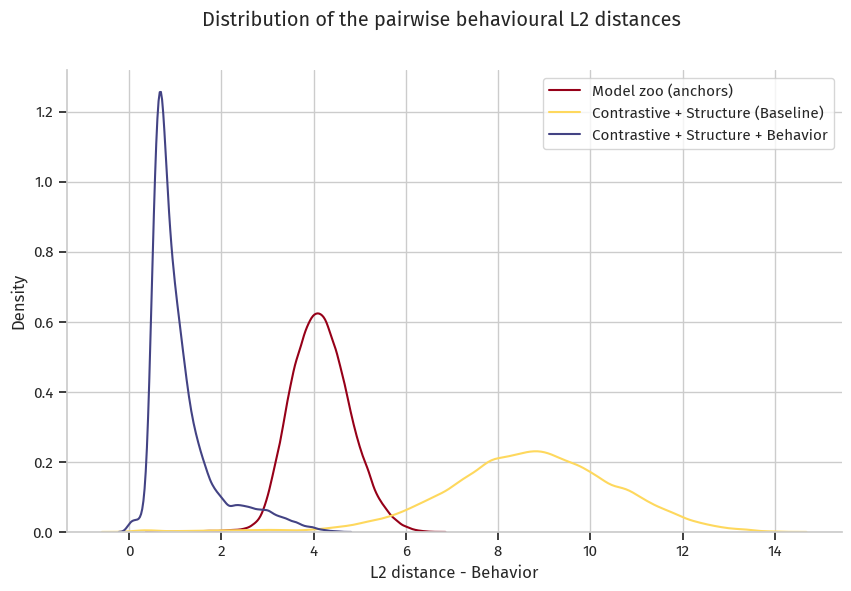

In [30]:
_, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(gen_diversity['Model zoo']['l2_behaviour'], color=COLOURS[0], label='Model zoo (anchors)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure (Baseline)']['l2_behaviour'], color=COLOURS[1], label='Contrastive + Structure (Baseline)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure + Behavior']['l2_behaviour'], color=COLOURS[2], label='Contrastive + Structure + Behavior', ax=ax)

ax.set(xlabel='L2 distance - Behavior')

plt.legend()
plt.suptitle('Distribution of the pairwise behavioural L2 distances')
plt.show()